In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import sys
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack, join
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr
import CL_richness as richness

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
theta_pivot = [3e14/0.71, 0.6]
theta_mu = [3.19, 0, 0.94]
theta_sigma = [0.33, 0,-0.08]

In [3]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# M200c-z halos

In [4]:
profile_SkySim = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_epsilon_shape_all_bins_ns.pkl')

In [5]:
len(profile_SkySim)

4725

In [6]:
profile_SkySim.colnames

['cluster_id',
 'M200c',
 'cluster_z',
 'radial_bin',
 'gt_av',
 'gx_av',
 'radius_av',
 'norm_sum']

In [7]:
z, logm = np.array([p['cluster_z'][0] for p in profile_SkySim]), np.array([np.log10(p['M200c'][0]) for p in profile_SkySim])

## generate richness following a mass-richness model

In [8]:
profile_SkySim['richness'] = np.exp(richness.lnLambda(z, logm, theta_mu, theta_sigma, theta_pivot))

[]

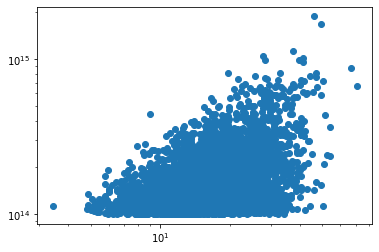

In [9]:
plt.scatter(profile_SkySim['richness'], profile_SkySim['M200c'])
plt.loglog()

In [10]:
profile_SkySim['halo_id'] = profile_SkySim['cluster_id']

In [11]:
profile_SkySim.colnames

['cluster_id',
 'M200c',
 'cluster_z',
 'radial_bin',
 'gt_av',
 'gx_av',
 'radius_av',
 'norm_sum',
 'richness',
 'halo_id']

In [12]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, .6, 5)
Z_bin = binning(z_corner)
logrichness_corner = np.linspace(np.log(min(profile_SkySim['richness'])), np.log(max(profile_SkySim['richness'])), 4)
richness_corner = np.exp(logrichness_corner)
Obs_bin = binning(richness_corner)

In [13]:
d,da, ds = np.histogram2d(profile_SkySim['richness'], z, bins = [richness_corner, z_corner])

In [14]:
d

array([[ 21.,  46.,  53.,  60.],
       [247., 339., 458., 538.],
       [ 42.,  77.,  95.,  71.]])

Weak lensing mass richness relation

In [15]:
profile_SkySim_cut = profile_SkySim
profile_SkySim_cut['richness'] = np.array([p['richness'] for p in profile_SkySim_cut])
profile_SkySim_cut['cluster_z'] = z

In [16]:
profile_stack_epsilon = prf.stacked_profile(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin, add_columns_to_bin = ['M200c'])
print(len(profile_stack_epsilon))
print('ok')
covariance_stack_epsilon = prf.bootstrap_covariance(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 200,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return gt_w/w, gx_w/w, r_w/w
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in true_divide
  return gt_w/w, gx_w/w, r_w/w
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


12
ok


[]

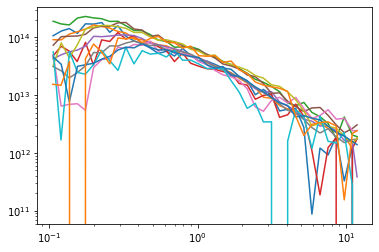

In [17]:
for i,p in enumerate(profile_stack_epsilon):
    plt.errorbar(p['radius'], p['gt'])
plt.loglog()

In [18]:
%time
fit_1h_free_c = fit.fit_WL_cluster_mass(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = 0, b = .8, rmax = 4, two_halo_term = False, fix_c = False)
fit_1h_fix_c = fit.fit_WL_cluster_mass(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = 0, b = .8, rmax = 4, two_halo_term = False, fix_c = True)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 20.3 µs


In [19]:
fits = [fit_1h_free_c,fit_1h_fix_c]
text = [ 'c-M, 1h','free c, 1h']

No handles with labels found to put in legend.


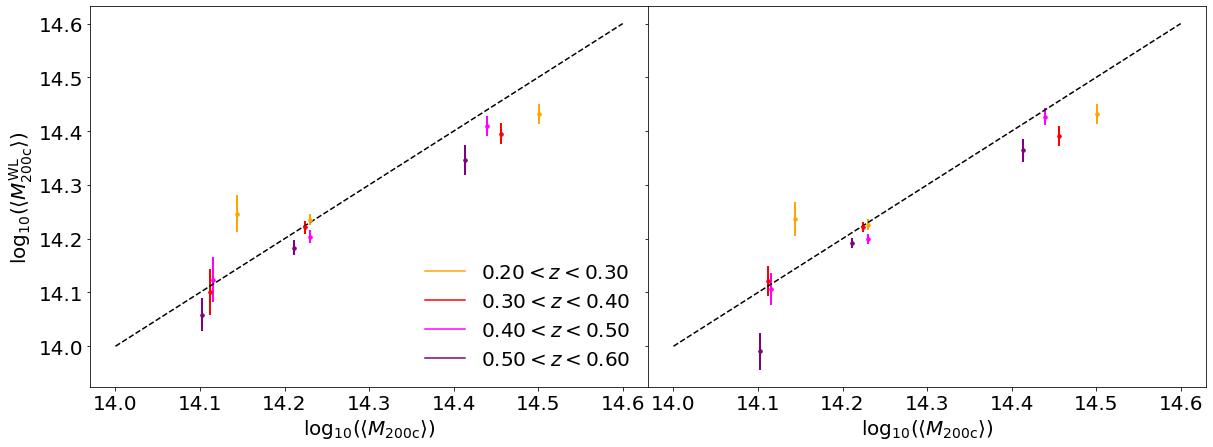

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (20,7), sharex=True, sharey=True)
plt.rcParams['axes.linewidth'] = 1
fig.subplots_adjust(wspace=0, hspace=0)
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
y = np.linspace(14, 14.6, 100)
for i,f in enumerate(fits):
    for k, z_bin in enumerate(Z_bin):
            if i == 0:
                
                axs[i].plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
            mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
            mask = mask*(f['n_stack'] > 10)
            f_cut = f[mask]
            logm200 = [np.log10(np.mean(m)) for m in f_cut['M200c']]
            logm200w = f_cut['logm200_w']
            logm200w_err = f_cut['logm200_w_err']
            axs[i].errorbar(logm200,logm200w,logm200w_err,
                    marker = '.', 
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k], fmt = ' ',
                        markerfacecolor = None)
    #axs[i_fits[i],j_fits[i]].set_xlim(14,14.8)
    #axs[i_fits[i],j_fits[i]].set_ylim(14,14.8)
    axs[i].plot(y,y,'--k')
    #axs[i].set_ylim(14,15)
    axs[i].tick_params(axis='both', which = 'major', labelsize= 20)
    axs[i].legend(frameon = False, fontsize = 20, loc = 'lower right')
    axs[i].set_xlabel(r'$\log_{10}(\langle M_{\rm 200c}\rangle)$', fontsize = 20)
    if i == 0:
        axs[i].set_ylabel(r'$\log_{10}(\langle M_{\rm 200c}^{\rm WL}\rangle)$', fontsize = 20)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_wl_mass_mass.png', bbox_inches='tight', dpi=300)